In [80]:
#!git clone https://github.com/MarcoForte/FBA-Matting.git

**Make sure runtime type is GPU**

In [81]:
#%cd ..
#!rm -rf FBA-Matting


In [82]:
#Download and unzip file
!gdown https://drive.google.com/uc?id=1AmdqDn0W6M8MCA9QnHsIjYRsFtwcP6l1
!unzip fba-matting.zip
!rm fba-matting.zip

Downloading...
From: https://drive.google.com/uc?id=1AmdqDn0W6M8MCA9QnHsIjYRsFtwcP6l1
To: /content/fba-matting.zip
141MB [00:00, 113MB/s] 
Archive:  fba-matting.zip
   creating: FBA-Matting/
   creating: FBA-Matting/__pycache__/
  inflating: FBA-Matting/__pycache__/trimap_module.cpython-36.pyc  
  inflating: FBA-Matting/__pycache__/dataloader.cpython-36.pyc  
  inflating: FBA-Matting/__pycache__/demo.cpython-36.pyc  
   creating: FBA-Matting/networks/
   creating: FBA-Matting/networks/__pycache__/
  inflating: FBA-Matting/networks/__pycache__/resnet_GN_WS.cpython-36.pyc  
  inflating: FBA-Matting/networks/__pycache__/__init__.cpython-36.pyc  
  inflating: FBA-Matting/networks/__pycache__/layers_WS.cpython-36.pyc  
  inflating: FBA-Matting/networks/__pycache__/models.cpython-36.pyc  
  inflating: FBA-Matting/networks/__pycache__/resnet_bn.cpython-36.pyc  
  inflating: FBA-Matting/networks/__pycache__/transforms.cpython-36.pyc  
  inflating: FBA-Matting/networks/resnet_GN_WS.py  
 extrac

In [83]:
%cd FBA-Matting

/content/FBA-Matting


In [84]:
#!git clone https://github.com/lnugraha/trimap_generator.git
#%cd trimap_generator
#!mv * ..
#%cd ..



In [85]:
from demo import np_to_torch, pred, scale_input
from dataloader import read_image, read_trimap
from networks.models import build_model
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [86]:
class Args:
  encoder = 'resnet50_GN_WS'
  decoder = 'fba_decoder'
  weights = 'FBA.pth'
args=Args()
try:
    model = build_model(args)
except:
    !gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
    model = build_model(args)

modifying input layer to accept 11 channels


In [87]:
image = read_image('./examples/images/troll.png')
print(image.shape)
trimap = read_trimap('./examples/trimaps/troll.png')
print(trimap.shape)

(640, 800, 3)
(640, 800, 2)


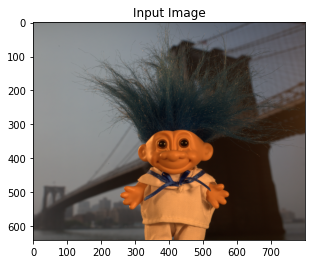

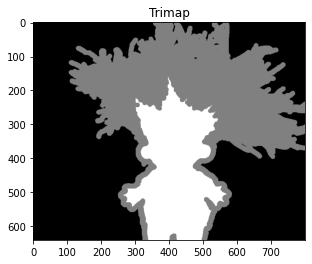

In [88]:
plt.title('Input Image')
plt.imshow(image)
plt.show()

# transform two channel trimap back to single channel
trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [89]:
fg, bg, alpha = pred(image, trimap, model)

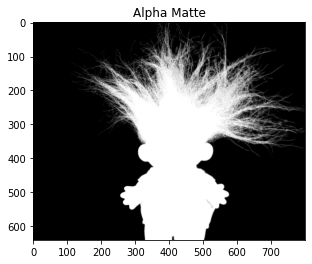

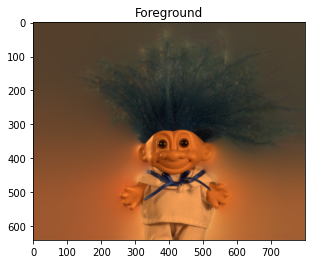

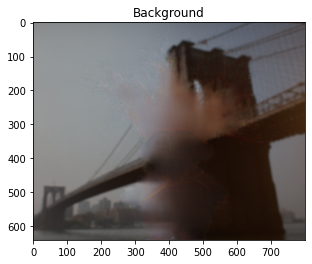

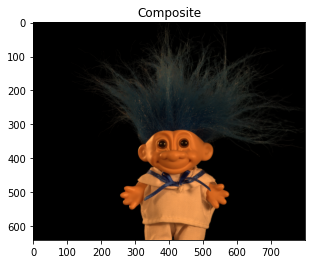

In [90]:
plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray', vmin=0, vmax=1)
plt.show()
plt.title('Foreground')
plt.imshow(fg)
plt.show()
plt.title('Background')
plt.imshow(bg)
plt.show()
plt.title('Composite')
plt.imshow(fg*alpha[:,:,None])
plt.show()

In [91]:
#Segment function
def segment(net, path, dev='cuda'):
  img = Image.open(path)
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out'] # [1,21,ho,wo]
  #om... [1,ho,wo]
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb_mask = decode_segmap_mask(om, path)

  
  return rgb_mask

In [92]:
def decode_segmap_mask(image, source):

  label_colors = np.array([ (192, 128, 128)])
  
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  #Llenar el array

  idx = image == 15
  r[idx] = label_colors[0][0]
  g[idx] = label_colors[0][1]
  b[idx] = label_colors[0][2]
  
  #Es la Imagen pintada
  #pegando todo los unit8 arrays en R*G*A
  rgb = np.stack([r, g, b], axis=2)
  plt.imshow(rgb); plt.axis('off'); plt.show()
  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb), 0, 255.0, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  kernel = np.ones((5,5), np.uint8)
  #Erosion + Dilation
  img_erosion = cv2.erode(alpha, kernel, iterations=1) 
  alpha = cv2.dilate(img_erosion, kernel, iterations=1)
  #alpha = alpha.astype(float)/255
  #alpha = alpha.astype(float)
  return alpha




In [93]:
#WE use pytorch pretainerd deeplab model resnet101 as backbone
import cv2
from torchvision import models
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from trimap_module import trimap
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [94]:
  def trimap_2(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake

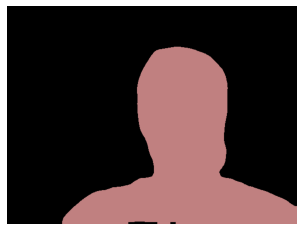

In [95]:
#Generate tri-map from mask using Method-1
from trimap_module import trimap, extractImage
mask = segment(dlab, './hector.png')
mask =  extractImage('./hector_mask.png')
#Generate Tri-map and save it
size    = 3; # how many pixel extension do you want to dilate
name    = "hector_mask_2";

number  = 1;  # numbering purpose 
#trimap(mask, name, size, number, erosion=True)#images/results/file

#Read Tri-Map and -Rescale
tri_map_2 =  read_trimap('./hector_mask.png')
#tri_map_2 =  read_trimap('./hector_mask2.png')
dim = (640, 480)
tri_map_2 = cv2.resize(tri_map_2, dim)

#Read original Image
img_2 = read_image('./hector.png')

#Get Results from model
fg_test_2, bg_test_2, alpha_test_2 = pred(img_2, tri_map_2, model)

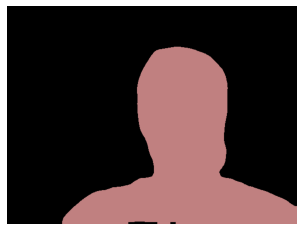

(480, 640, 3)
(480, 640, 3)


In [96]:
#Generate tri-map from mask using Method-2
mask = segment(dlab, './hector.png')
tri_map = trimap_2(mask, 7, 0.95)
dim = (640, 480)

tri_map = cv2.resize(tri_map, dim)
cv2.imwrite('generated_trimap.png', tri_map)
print(tri_map.shape)

img = read_image('./hector.png')

tri_map = read_trimap('generated_trimap.png')
print(img.shape)

fg_test, bg_test, alpha_test = pred(img, tri_map, model)


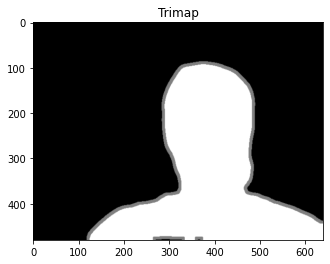

(480, 640, 3)
(480, 640, 3)
(480, 640)


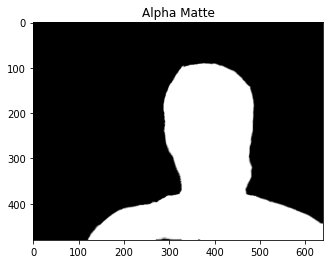

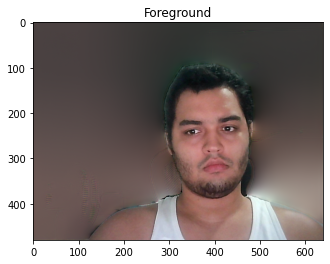

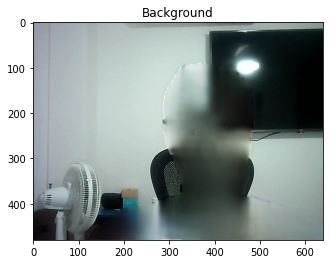

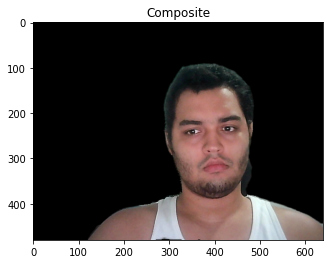

In [97]:
#Print Results Method-2
trimap_im =  tri_map_2[:,:,1] + (1-np.sum(tri_map_2,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

print(fg_test_2.shape)
print(bg_test_2.shape)
print(alpha_test_2.shape)

plt.title('Alpha Matte')
plt.imshow(alpha_test_2, cmap='gray', vmin=0, vmax=1)
plt.show()

plt.title('Foreground')
plt.imshow(fg_test_2)
plt.show()

plt.title('Background')
plt.imshow(bg_test_2)
plt.show()

plt.title('Composite')
plt.imshow(fg_test_2*alpha_test_2[:,:,None])
plt.show()


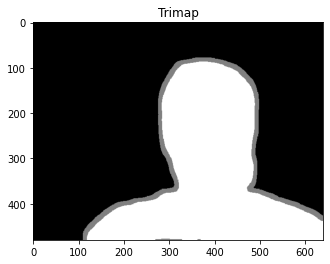

(480, 640, 3)
(480, 640, 3)
(480, 640)


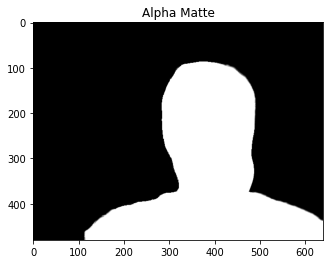

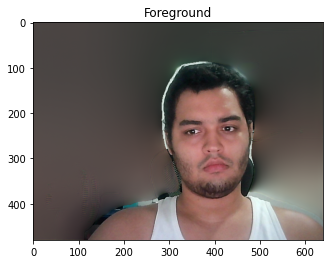

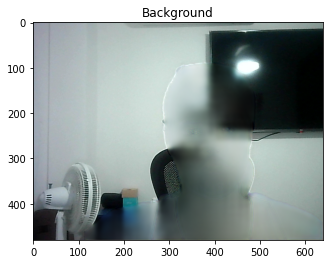

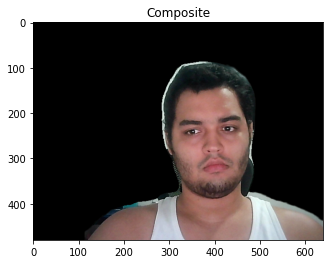

In [98]:
#Print Results Method-1
trimap_im =  tri_map[:,:,1] + (1-np.sum(tri_map,-1))/2
plt.title('Trimap')
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

print(fg_test.shape)
print(bg_test.shape)
print(alpha_test.shape)

plt.title('Alpha Matte')
plt.imshow(alpha_test, cmap='gray', vmin=0, vmax=1)
plt.show()

plt.title('Foreground')
plt.imshow(fg_test)
plt.show()

plt.title('Background')
plt.imshow(bg_test)
plt.show()

plt.title('Composite')
plt.imshow(fg_test*alpha_test[:,:,None])
plt.show()



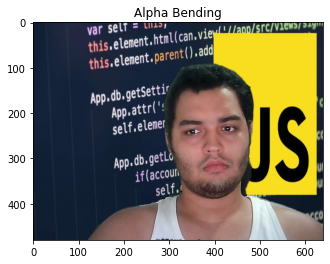

In [99]:
#Alpha Bending  Method-2
plt.title('Alpha Bending')
bg_test_2 = read_image('./js.png')
dim = (640, 480)
bg_test_2 = cv2.resize(bg_test_2, dim)
foreground_2 = fg_test_2 * alpha_test_2[:,:,None]
background_2 = ( 1.0 - alpha_test_2[:,:,None]) * bg_test_2
result_2 = foreground_2 + background_2
plt.imshow(result_2)
plt.show()

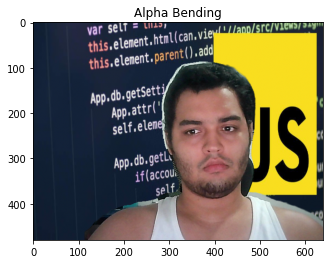

In [100]:
#Alpha Bending  Method-1
plt.title('Alpha Bending')
bg_test = read_image('./js.png')
dim = (640, 480)
bg_test = cv2.resize(bg_test, dim)
foreground = fg_test * alpha_test[:,:,None]
background = ( 1.0 - alpha_test[:,:,None]) * bg_test
result = foreground + background
plt.imshow(result)
plt.show()